In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

# Chapter 4 - GEOCENTRIC MODELS

### End of chapter problems

### 4E1.

In the model definition below, which line is the likelihood?

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

#### Answer 
The first line defines the likelihood

### 4E2.
In the model definition just above, how many parameters are in the posterior distribution?

#### Answer 
There are two parameters in the posterior, $\mu $ and $\sigma$

### 4E3.
Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors

#### Answer 


$ Pr(\mu,\sigma | \underline{x}) = \frac{Pr(\underline{x}|\mu,\sigma)Pr(\mu)Pr(\sigma)}{Pr(\underline{h})} \propto \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2) \times  exp(-\frac{1}{2}(\frac{\mu}{10})^2) \times exp(-\sigma)$

$ \implies Pr(\mu,\sigma | \underline{x}) = \frac{\frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma)}{\int \int \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma) d\mu d\sigma}$

### 4E4.
In the model definition below, which line is the linear model?
yi ∼ Normal(µ, σ)

µi = α + βxi

α ∼ Normal(0, 10)

β ∼ Normal(0, 1)

σ ∼ Exponential(2)

#### Answer 
The second line. It encodes the linear dependence of the mean of the likelihood on the predictor variable, xi

### 4E5.
In the model definition just above, how many parameters are in the posterior distribution?

#### Answer 
There are three paramaters in the posterior distribution. $\alpha$, $\beta$, and $\sigma$.

### 4M1.
For the model definition below, simulate observed y values from the prior (not the posterior).

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

In [3]:
# simulate the prior predictive distribution for 1,000 samples
mu = np.random.normal(0, 10, size=1000)  # prior for mu
sigma = np.random.exponential(1, size=1000)  # prior for sigma
# get the samples from the likelihood
y = np.random.normal(mu, sigma)

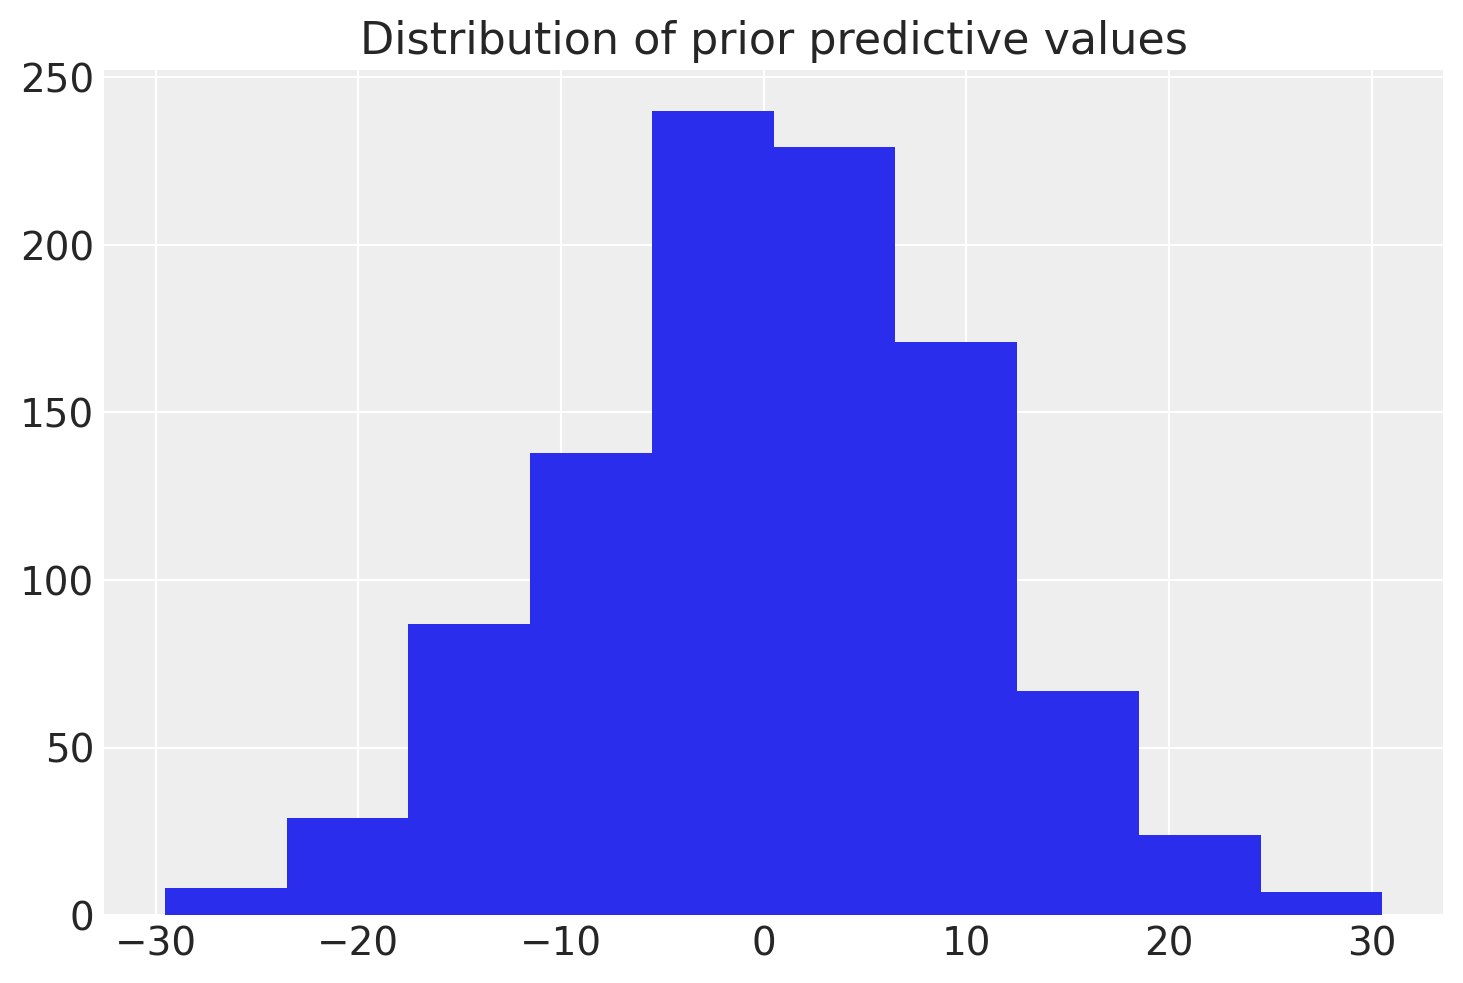

In [4]:
plt.title("Distribution of prior predictive values")
plt.hist(y);

### 4M2.
Translate the model just above into a quap formula.

#### Answer 
N/A. This is a function in the statistical rethinking R package

4M3: Ditto

### 4M4.

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

#### Answer 


I'm assuming these are young students who grow linearly with time

Let $h_i, y,\mu, \sigma$ be height, year/time since first measurement, mean and standard deviation respectively

$h_i$ ~ $N(\mu,\sigma^2)$ #As height is roughly normally distributed and the variance is constant with age. On a 3 year time scale, and for a simple model, I don't see why height variance would alter substantially with age. This is a sketchy assumption, and one could opt to include some temporal dependence in the variance.

$\mu = \alpha + \beta y$ #Assume the mean has some linear dependence on time

$\alpha$ ~ $N(1,0.1^2)$ #Assume the students are toddlers around the 1 metre height mark at the start of the measuring time. The standard deviation allows for a modest range of heights, but nothing to fantastical like 0 or 2 metres tall.

$\beta$ ~ $logN(0,1)$ #It seems perfectly sensible that the amount an average student's height changes per year should only be positive. Additionally, I have no idea what the growth rate is so this enocodes ignorance about the rate of change of height per year

$\sigma$ ~ $Unif(0,50)$

### 4M5. 

Now suppose I remind you that every student got taller each year. Does this information lead
you to change your choice of priors? How?

#### Answer 
No it does not. I already factored this in by using a log normal distribution on $\beta$

### 4M6.
Now suppose I tell you that the variance among heights for students of the same age is never
more than 64cm. How does this lead you to revise your priors?

#### Answer 
This would cause me to use an even larger range of plausable values in my prior for $\sigma$. Given my assumption for the students ages, increasing the range seems to be not sensible for the data at hand.

### 4M7.

Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the
new model’s posterior to that of the original model. In particular, look at the covariance among the
parameters. What is different? Then compare the posterior predictions of both models.

In [5]:
# get the data for the adults
# load in the data
howell1 = pd.read_csv("./../data/Howell1.csv", delimiter=";")
data = howell1[howell1.age >= 18]

In [6]:
with pm.Model() as m4_1:
    alpha = pm.Normal("alpha", mu=178, sd=20)  # prior on alpha
    beta = pm.Lognormal("beta", mu=0, tau=1)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta * data.weight.values
    height = pm.Normal("height", mu=mu, sd=sigma, observed=data.height)  # likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])


{'alpha': array(114.5342983), 'beta_log__': array(-0.11571346), 'sigma_interval__': array(-2.18116842), 'beta': array(0.89073042), 'sigma': array(5.07271819)}


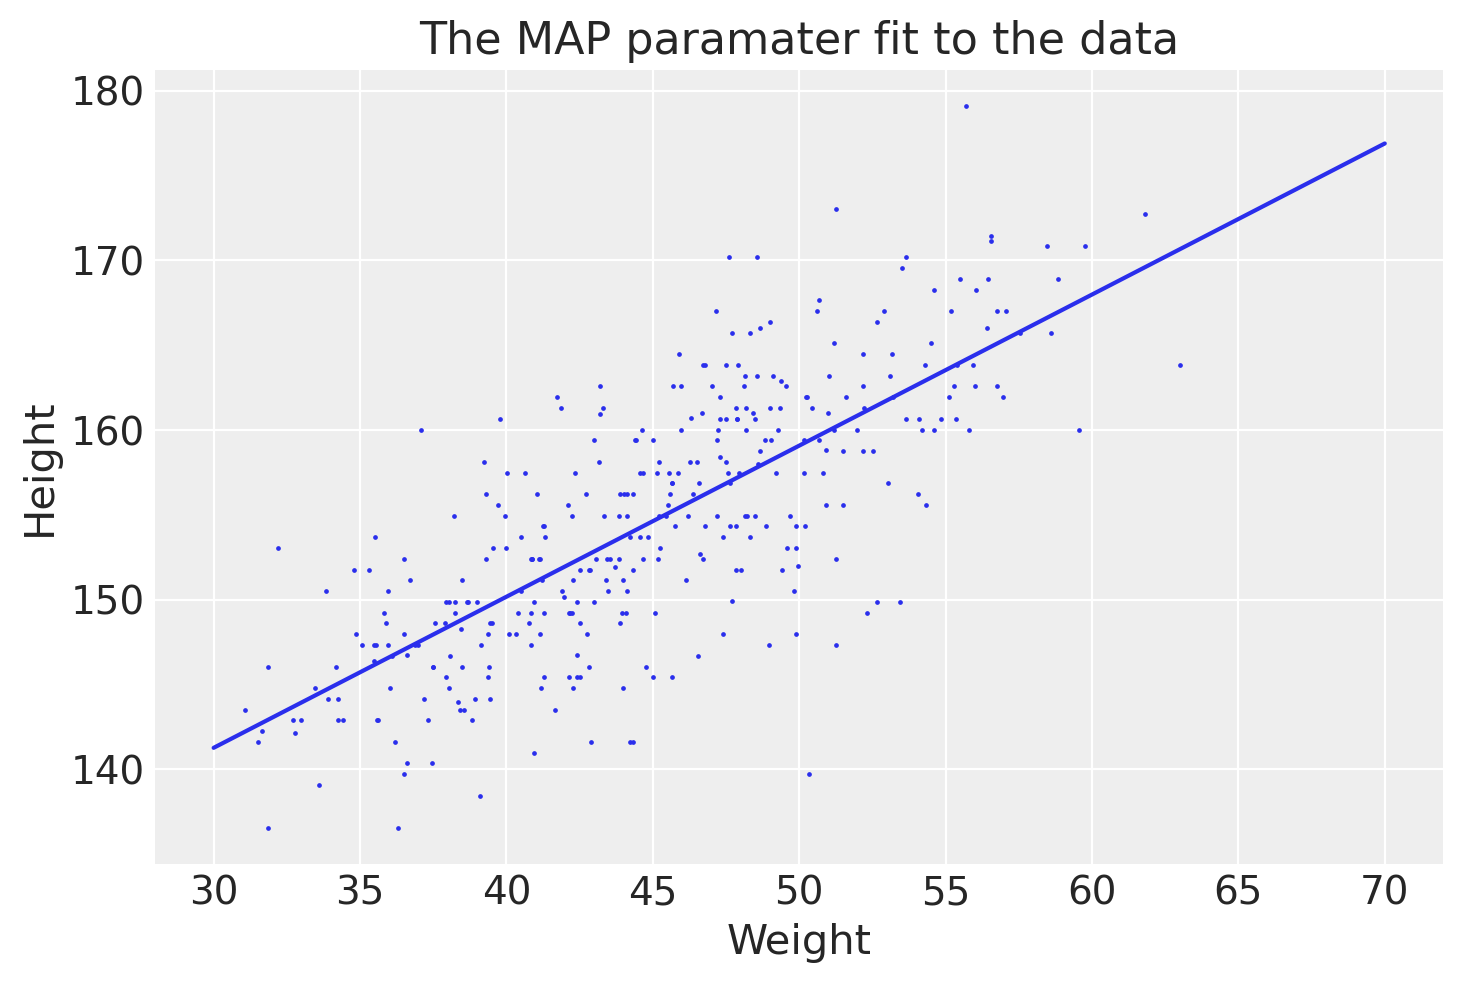

In [7]:
mu = mean_q["alpha"] + mean_q["beta"] * (np.linspace(30, 70, 100))
plt.plot(np.linspace(30, 70, 100), mu)
plt.scatter(data.weight, data.height, s=0.5)
plt.title("The MAP paramater fit to the data")
plt.xlabel("Weight")
plt.ylabel("Height");

In [8]:
var_cov = np.linalg.inv(Hess)

In [9]:
np.mean(data.weight) * 0.9 + mean_q["alpha"]

155.02573526867684

In [10]:
var_cov, mean_q

(array([[ 3.60234135e+00, -7.84577731e-02,  9.35920755e-03],
        [-7.84577731e-02,  1.74417272e-03, -2.04346411e-04],
        [ 9.35920755e-03, -2.04346411e-04,  3.65761511e-02]]),
 {'alpha': array(114.5342983),
  'beta_log__': array(-0.11571346),
  'sigma_interval__': array(-2.18116842),
  'beta': array(0.89073042),
  'sigma': array(5.07271819)})

As the quap method approximates with a normal distribution, we can simply get the get the 89% compatibility interval of the $\beta$ parameter by finding the central 89% interval of a Gaussian with the location and scale parameters found from the quadratic approximation.

In [11]:
stats.norm.interval(0.89, loc=mean_q["beta"], scale=np.sqrt(var_cov[1, 1]))

(0.8239846054328593, 0.9574762250960549)

The off diagonal elements of the covariance matrix are negligible. Therefore one expects only a week correlation to be found between these paramater values. Using the multivatiate gaussian approximation to the posterior, we can take samples of the line parameters of the posterior and plot them against the actual data.

In [12]:
means = np.fromiter(mean_q.values(), dtype=float)[[0, 3, 4]]

In [13]:
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(30, 70)]
)

We may also wish to know the prediction intervals on the data. The plot above captures our uncertainty in the paramater values, as given by the posterior distribution. However, we would also like to know incorporate our uncertainty in the range of height outcomes at any given value of weight. This is captured by $\sigma$ in our model. This is given by the posterior predictive distribution at each value.

In [14]:
# define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x)

In [15]:
# compute the prediction interval in one line
pred_intervals = np.array(
    [
        az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2]))
        for x in np.linspace(30, 70)
    ]
)

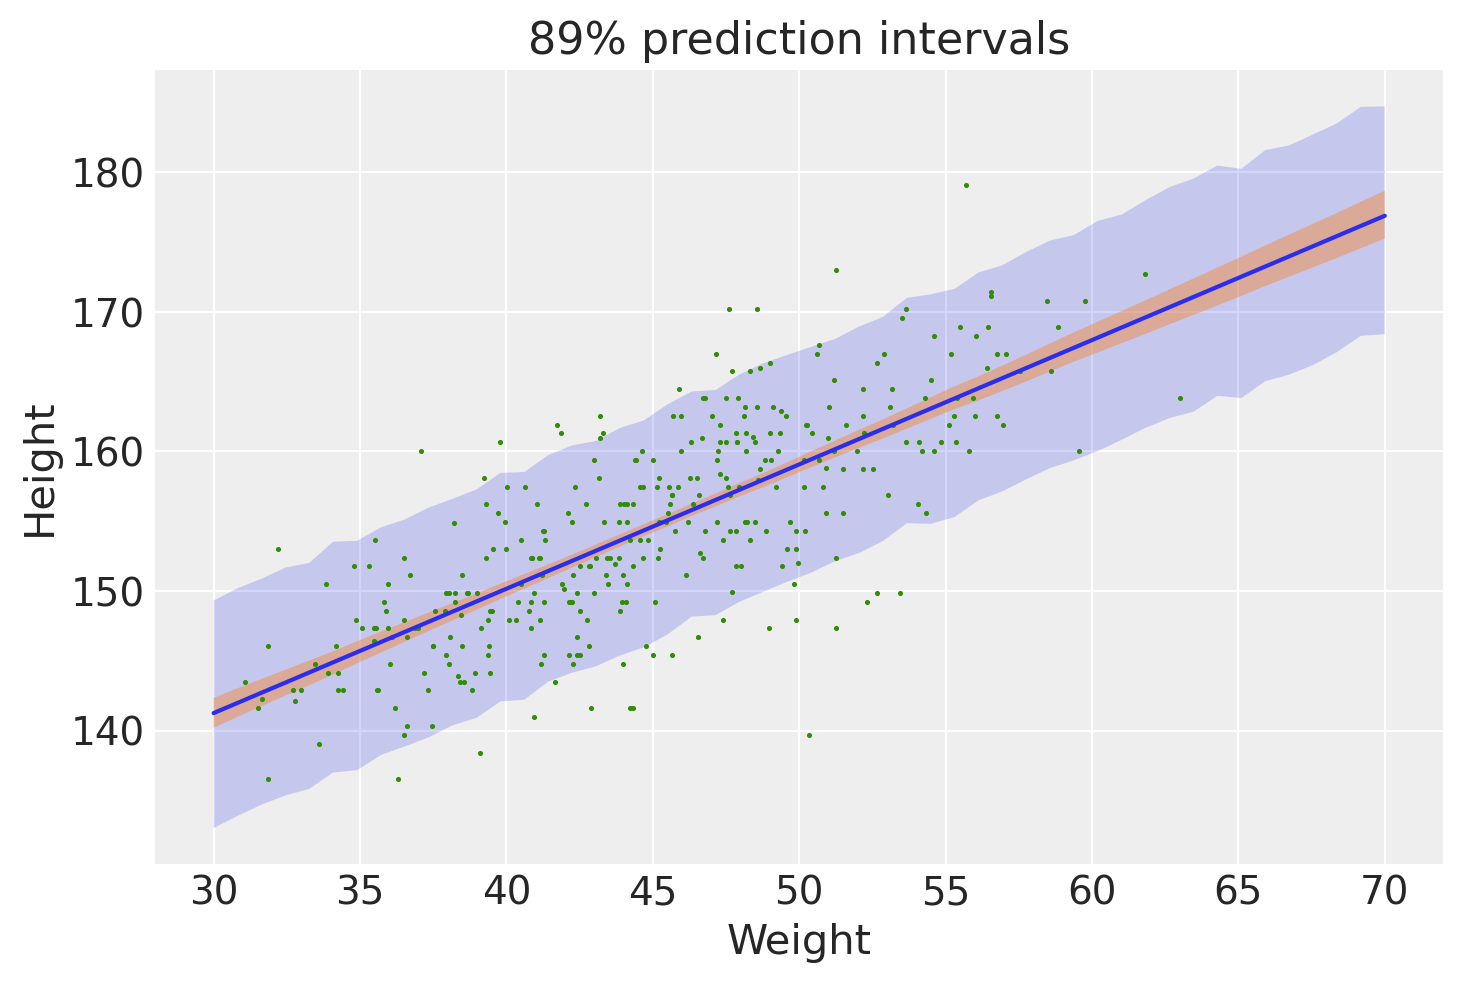

In [16]:
plt.fill_between(np.linspace(30, 70), pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2)
plt.fill_between(np.linspace(30, 70), cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.4)
plt.plot(np.linspace(30, 70, 100), mu)
plt.scatter(data.weight, data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals");

It can be seen that the predictions and the posterior values themselves look rather similar to each other. However the in the variance-covariance matrix appear to be a couple of orders of magnitude larger when one doesn't subtract the mean values from the data. Why is this? It's because the parameters signify different things in the two different models.

Inspect the model again:

Originally we had

$\mu_i = \alpha + \beta(x_i - \bar{x})$

and in the second run we are instead deciding to fit

$\mu_i = \alpha' + \beta x_i$

We can see that doing this in no way changes the model that is being fit to the data as we can derive one from the other as follows

$\mu_i = \alpha + \beta(x_i - \bar{x}) = \alpha - \beta \bar{x} + \beta x_i = \alpha' + \beta x_i$

That is to say

$ \alpha' = \alpha - \beta \bar{x}$

So as we can see, we can literally derive one parameter from the other. So why is the variance and covariance for the posterior of $\alpha'$ so much larger than for $\alpha$? It's because of what these parameters represent. For $\alpha$, it can be seen that $\mu = \alpha$ when $x = \bar{x}$. That is $\alpha$ represents the mean height at the mean weight. Therefore, the uncertainty in $\alpha$ is equivalent to the uncertainty in $\mu$ when $x = \bar{x}$, the mean of the weight. On the other hand, $\mu = \alpha'$ when $x = 0$, that is $\alpha$ represent the y-intercept of the data. Inspecting the plot below makes it much clearer what is going on here.

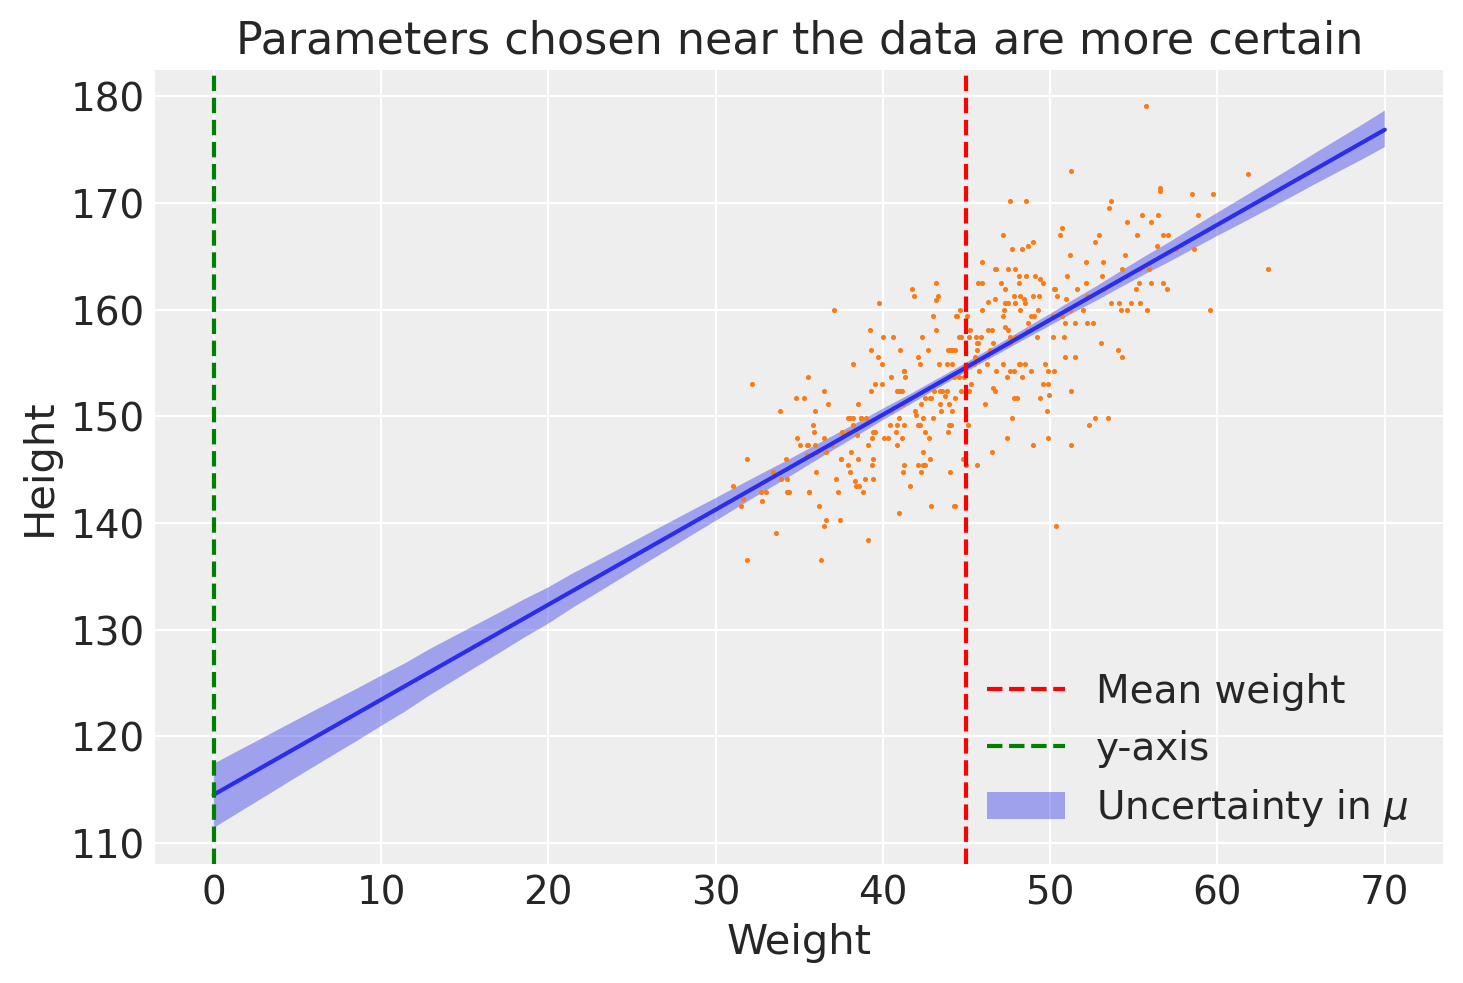

In [17]:
mu = mean_q["alpha"] + mean_q["beta"] * (np.linspace(0, 70, 100))
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(0, 70)]
)
plt.fill_between(
    np.linspace(0, 70),
    cred_intervals[:, 0],
    cred_intervals[:, 1],
    alpha=0.4,
    label=r"Uncertainty in $\mu$",
)
plt.plot(np.linspace(0, 70, 100), mu)
plt.scatter(data.weight, data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.axvline(np.mean(data.weight), ls="--", c="r", label="Mean weight")
plt.axvline(0, ls="--", c="g", label="y-axis")
plt.title("Parameters chosen near the data are more certain")
plt.legend();

It can be clearly seen that the uncertainty in the parameter in $\mu$ and therefore $\alpha'$ is much larger at the y intercept. This is represented by the larger hpdi band near the green line. On the the hpdi near the mean weight is very narrow. Intuitively this is because there's no data near the y intercept, therefore the uncertainty in this region is far less constrained by our observations compared to the uncertainty near $\mu$ where data abounds.

### 4H1.

The weights listed below were recorded in the !Kung census, but heights were not recorded for
these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is,
fill in the table below, using model-based predictions.

| Individual | Weight | Expected height | 89% interval|
|------|------|-------|-----|
|   1  | 46.95|?|?|
|   2  | 43.72|?|?|
|   3  | 64.78|?|?|
|   4  | 32.59|?|?|
|   5  | 54.63|?|?|

In [18]:
# define the data
individuals = np.linspace(1, 5, 5)
weight = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
# compute the mean predictions
means = mean_q["alpha"] + mean_q["beta"] * weight
# compute the prediction intervals
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in weight]
)
data_dict = {
    "Individual": individuals,
    "Weight": weight,
    "Expected height": means,
    "Low_interval": pred_intervals[:, 0],
    "Upper_interval": pred_intervals[:, 1],
}

In [19]:
# present everything in a pandas dataframe
pd.DataFrame(data=data_dict)

,Individual,Weight,Expected height,Low_interval,Upper_interval
0,1.0,46.95,156.354091,148.686629,165.006168
1,2.0,43.72,153.477032,145.139440,161.406080
2,3.0,64.78,172.235815,163.591119,180.066446
3,4.0,32.59,143.563203,135.192446,151.640268
4,5.0,54.63,163.194901,154.721403,170.918289


### 4H2.

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For
every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval
for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.



In [20]:
# get the young data
y_data = howell1[howell1.age < 18]

In [21]:
# check the correct amount of data is present
y_data.shape

(192, 4)

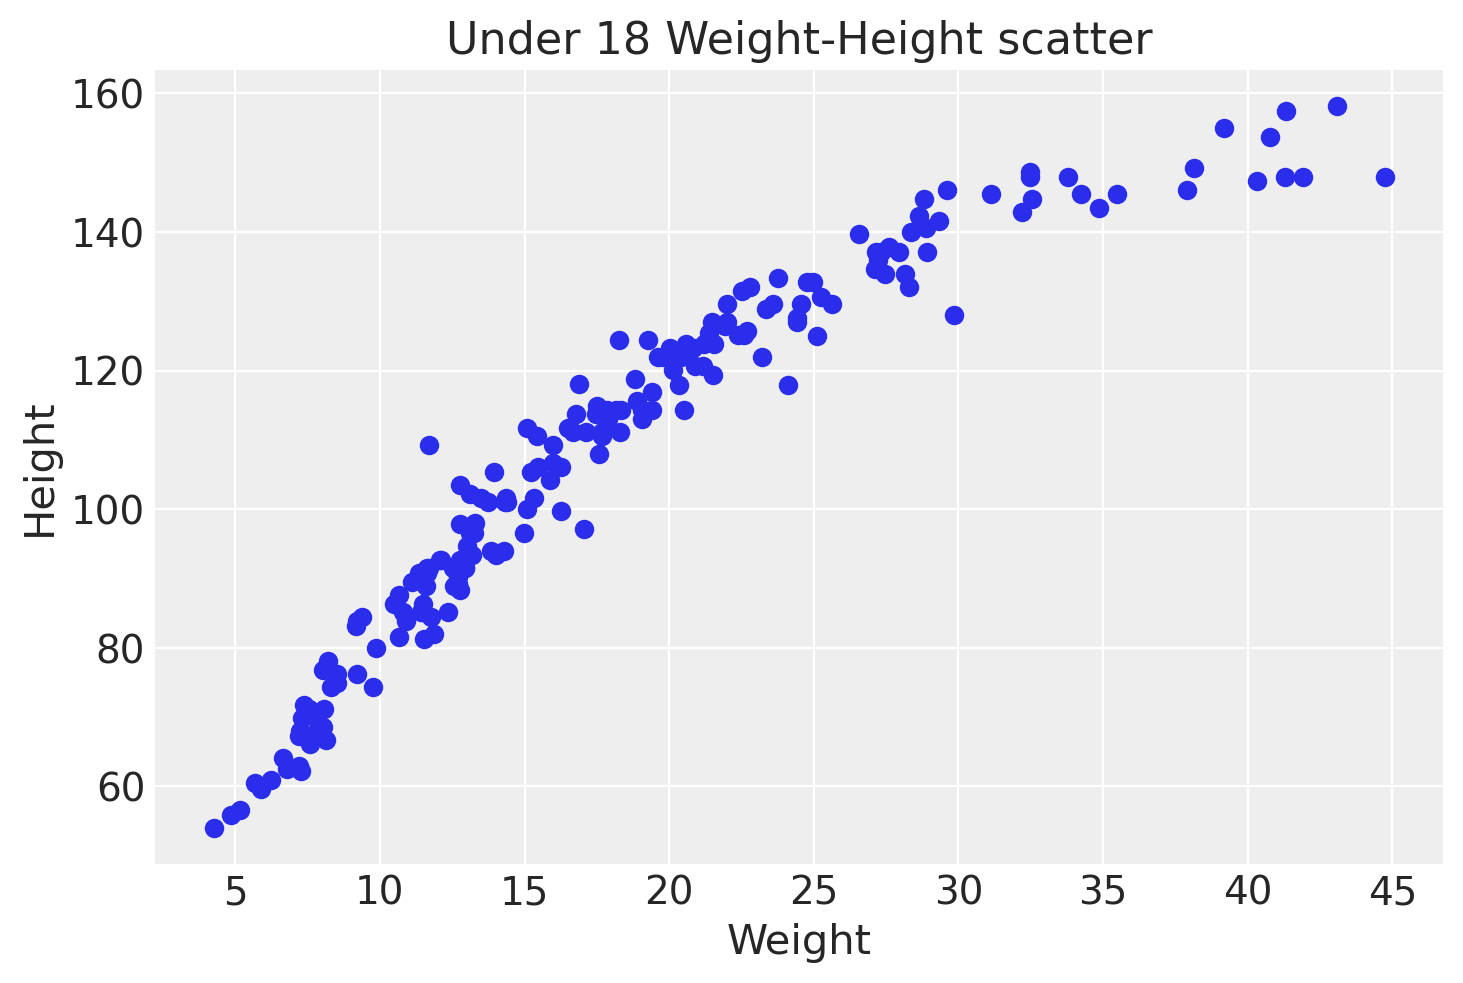

In [22]:
# check out the data
plt.scatter(y_data.weight, y_data.height)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Under 18 Weight-Height scatter");

I lazily fit the same model from earlier

$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(x_i - \bar{x})$

$\alpha$ ~ $log-N(178,20^2)$

$\beta$ ~ $N(0,10)$

$\sigma$ ~ $Unif(0,50)$

In [23]:
np.mean(y_data.weight.values)

18.414193058854167

In [24]:
# obtain a linear model with the quadtratic approximation
with pm.Model() as m4_1:
    alpha = pm.Normal("alpha", mu=178, sd=20)  # prior on alpha
    beta = pm.Lognormal("beta", mu=0, tau=1)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta * (y_data.weight.values - np.mean(y_data.weight.values))
    height = pm.Normal(
        "height", mu=mu, sd=sigma, observed=y_data.height.values
    )  # likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])


{'alpha': array(110.51577411), 'beta_log__': array(0.95429403), 'sigma_interval__': array(36.49940751), 'beta': array(2.59683665), 'sigma': array(50.)}


In [25]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0, 3, 4]]
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [
        az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x - np.mean(y_data.weight)))
        for x in np.linspace(0, 50)
    ]
)
# define a function to compute mu for all posterior samples at given value of x

<ipython-input-25-17925886c0dc>:4: RuntimeWarning: covariance is not positive-semidefinite.
  post_samples = np.random.multivariate_normal(means, var_cov, size=10000)


In [26]:
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x - np.mean(y_data.weight))

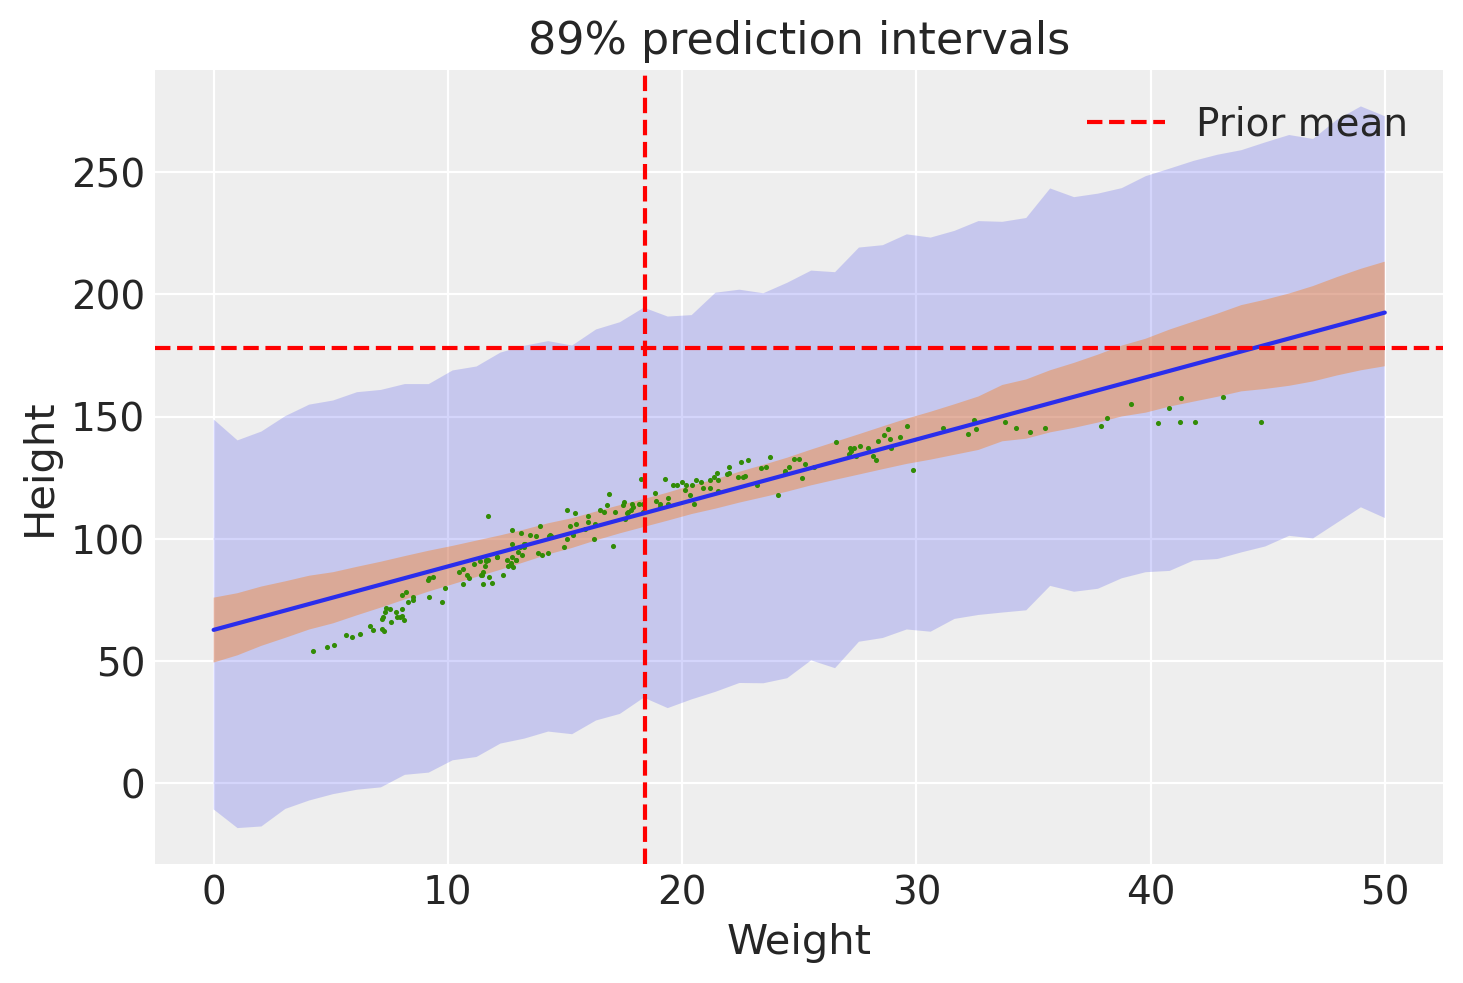

In [27]:
# compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"] * (np.linspace(0, 50, 100) - np.mean(y_data.weight))
pred_intervals = np.array(
    [
        az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2]))
        for x in np.linspace(0, 50)
    ]
)
plt.fill_between(np.linspace(0, 50), pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2)
plt.fill_between(np.linspace(0, 50), cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.4)
plt.plot(np.linspace(0, 50, 100), mu)
plt.scatter(y_data.weight, y_data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--", c="r")
plt.axhline(178, ls="--", c="r", label="Prior mean")
plt.legend();

As can be seen, this gives absurdly large prediction intervals. This is because I chose a stupid prior for $\alpha$, which is the mean height at the mean weight. This is indicated by the crossover of the red lines above. If, we set the prior as $\alpha$ ~ $N(100,20^2)$ and then re-run everything, we see that we get far more sensible results for the data.

In [28]:
# obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal("alpha", mu=100, sd=20)  # prior on alpha
    beta = pm.Lognormal("beta", mu=0, tau=1)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta * (y_data.weight.values - np.mean(y_data.weight.values))
    height = pm.Normal(
        "height", mu=mu, sd=sigma, observed=y_data.height.values
    )  # likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])


{'alpha': array(108.31115082), 'beta_log__': array(0.99940212), 'sigma_interval__': array(-1.5945605), 'beta': array(2.71665711), 'sigma': array(8.4371617)}


In [29]:
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x - np.mean(y_data.weight))

In [30]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0, 3, 4]]
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [
        az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x - np.mean(y_data.weight)))
        for x in np.linspace(0, 50)
    ]
)
# define a function to compute mu for all posterior samples at given value of x

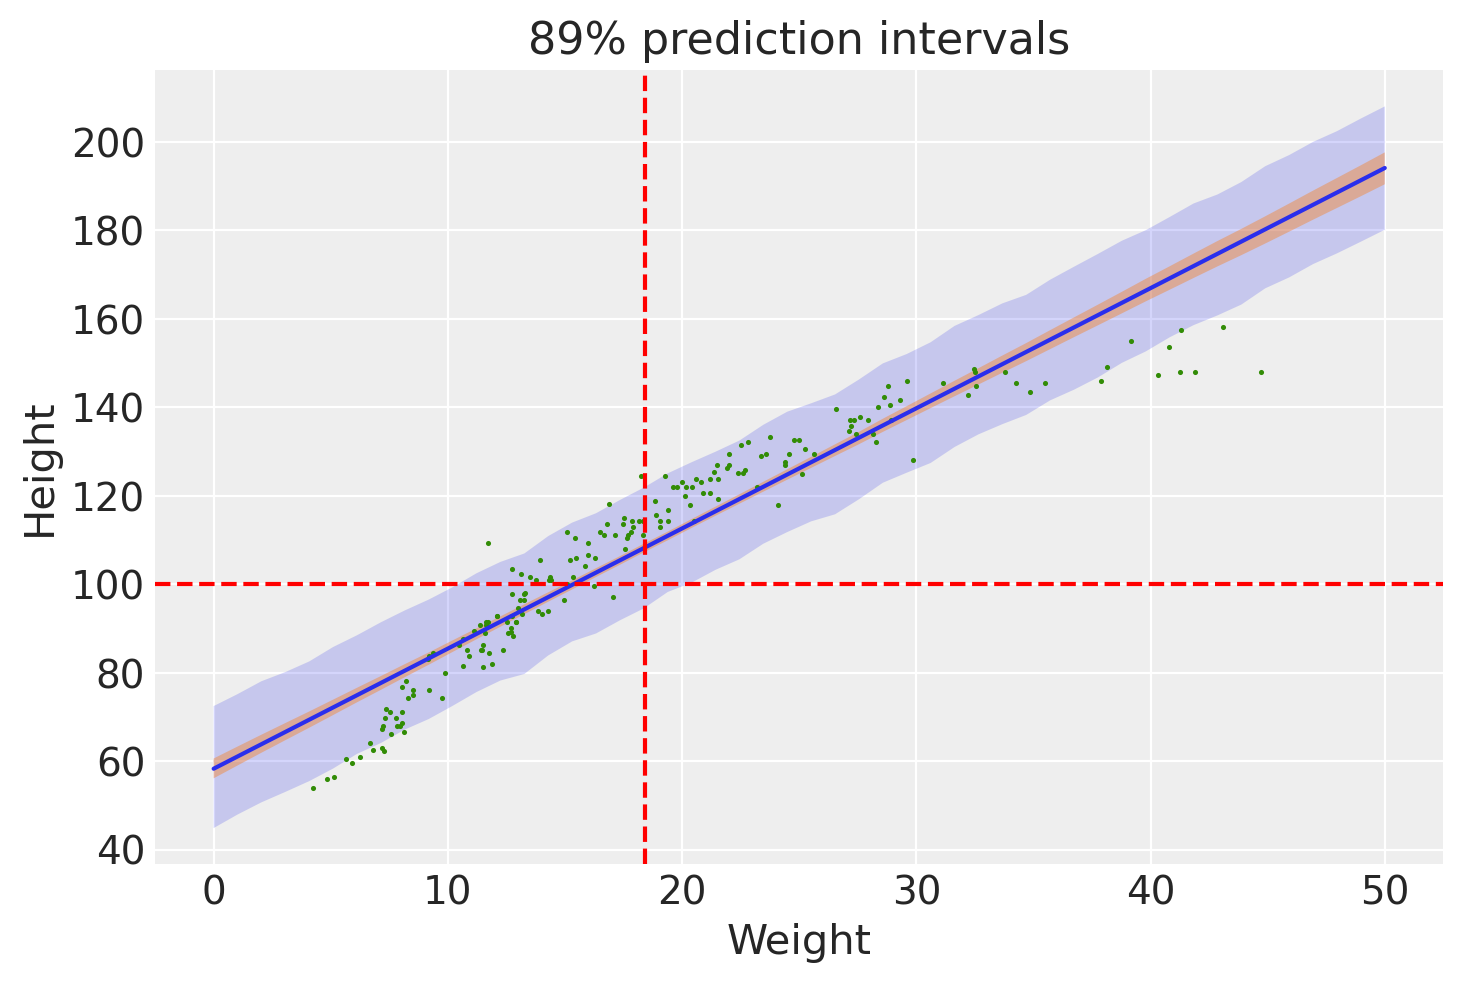

In [31]:
# compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"] * (np.linspace(0, 50, 100) - np.mean(y_data.weight))
pred_intervals = np.array(
    [
        az.hdi(
            np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2]),
        )
        for x in np.linspace(0, 50)
    ]
)
plt.fill_between(np.linspace(0, 50), pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2)
plt.fill_between(np.linspace(0, 50), cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.4)
plt.plot(np.linspace(0, 50, 100), mu)
plt.scatter(y_data.weight, y_data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--", c="r", label="Mean weight")
plt.axhline(100, ls="--", c="r", label="Mean weight");

This is a much better fit and the narrow prediction intervals reflect this. The model is still poor in many regards. This includes the failure of the model to capture the non-linear variation of height with weight, which results in poor predictions at the extreme ends of the distribution. The reason the linearity breaks down is fairly intuitive. If I over consume food, my weight will go up, but my height will not. Consumption is a contributing factor to weight, but not height that violates the model's linear assumption. Trying a non-linear model would help aid in the prediction at the tails.

### 4H3.
Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting
estimates?

(b) Begin with this plot: plot( height ~ weight , data=Howell1 ). Then use samples
from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the
predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97%
interval for predicted heights

In [32]:
# produce the new log_weight feature
howell1["log_weight"] = np.log(howell1.weight)

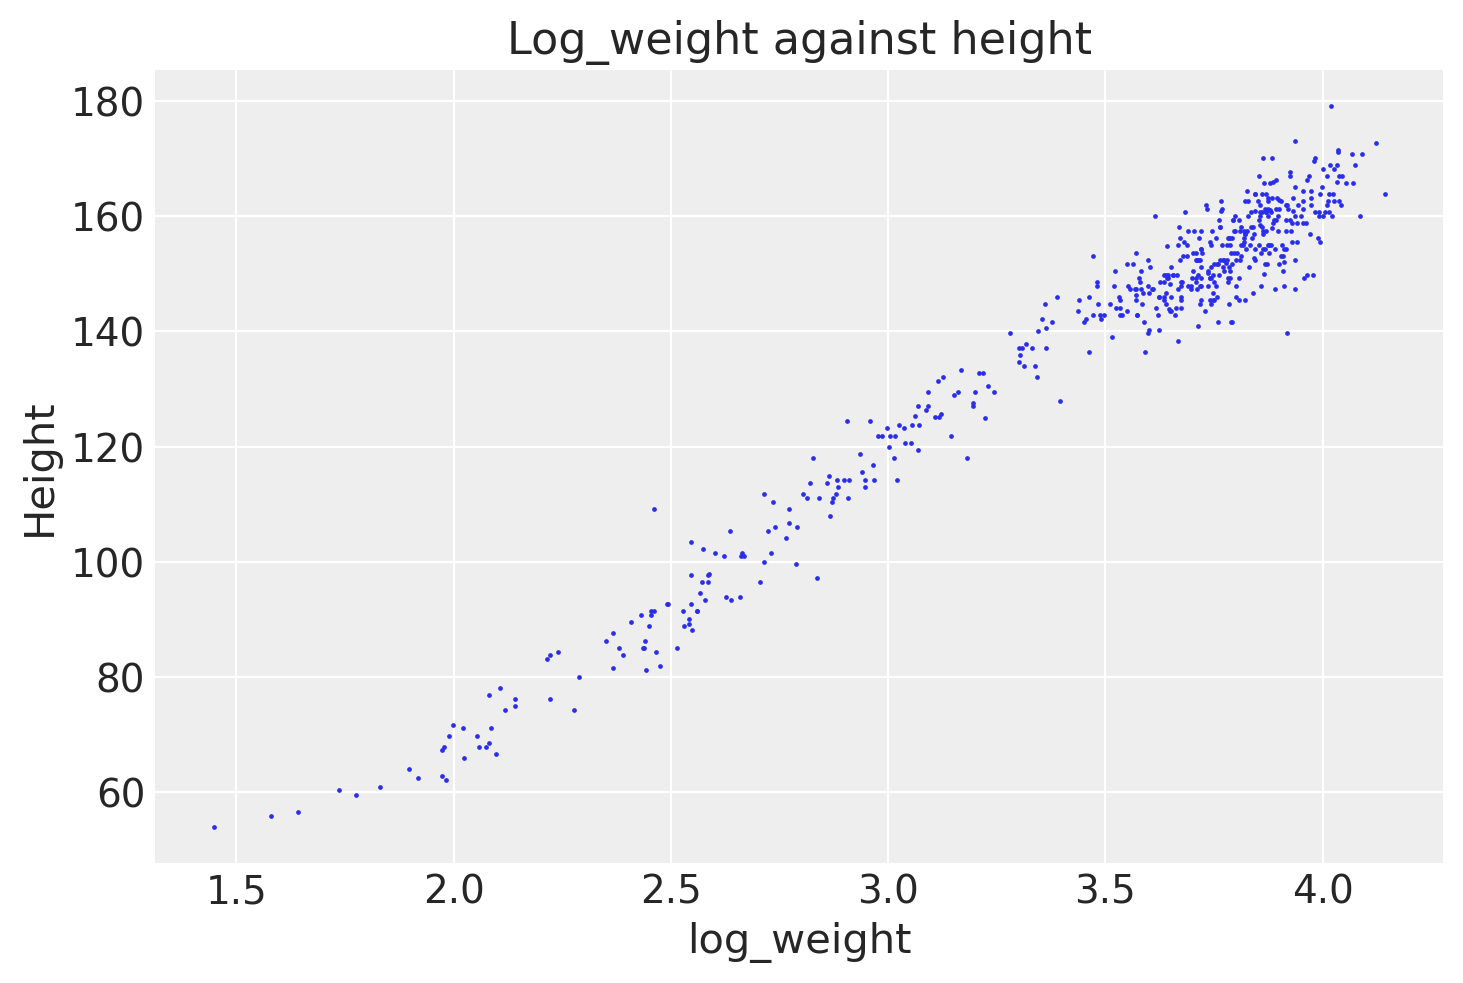

In [33]:
plt.title("Log_weight against height")
plt.scatter(howell1.log_weight, howell1.height, s=0.5)
plt.xlabel("log_weight")
plt.ylabel("Height");

In [34]:
howell1

,height,weight,age,male,log_weight
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302
...,...,...,...,...,...
539,145.415,31.127751,17.0,1,3.438100
540,162.560,52.163080,31.0,1,3.954375
541,156.210,54.062496,21.0,0,3.990141
542,71.120,8.051258,0.0,1,2.085828


In [35]:
np.mean(howell1.log_weight)

3.442329848013859

Let's use the following model for the relationship between log weight and height.


$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(log(x_i) - log(\bar{x}))$

$\alpha$ ~ $N(178,20^2)$

$\beta$ ~ $Log-N(1,10)$

$\sigma$ ~ $Unif(0,50)$

In [36]:
# obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal("alpha", mu=178, sd=20)  # prior on alpha
    beta = pm.Lognormal("beta", mu=0, tau=1)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta * (howell1.log_weight.values - np.mean(howell1.log_weight.values))
    # likelihood of the data
    height = pm.Normal("height", mu=mu, sd=sigma, observed=howell1.height.values)
    mean_q = pm.find_MAP()
    print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])


{'alpha': array(138.26840263), 'beta_log__': array(3.85166003), 'sigma_interval__': array(-2.16764365), 'beta': array(47.07113773), 'sigma': array(5.13469817)}


In [37]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0, 3, 4]]
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [
        az.hdi(
            post_samples[:, 0] + post_samples[:, 1] * (np.log(x) - np.mean(howell1.log_weight)),
            hdi_prob=0.97,
        )
        for x in np.linspace(0, 50)
    ]
)
# define a function to compute mu for all posterior samples at given value of x

In [38]:
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x - np.mean(howell1.log_weight))

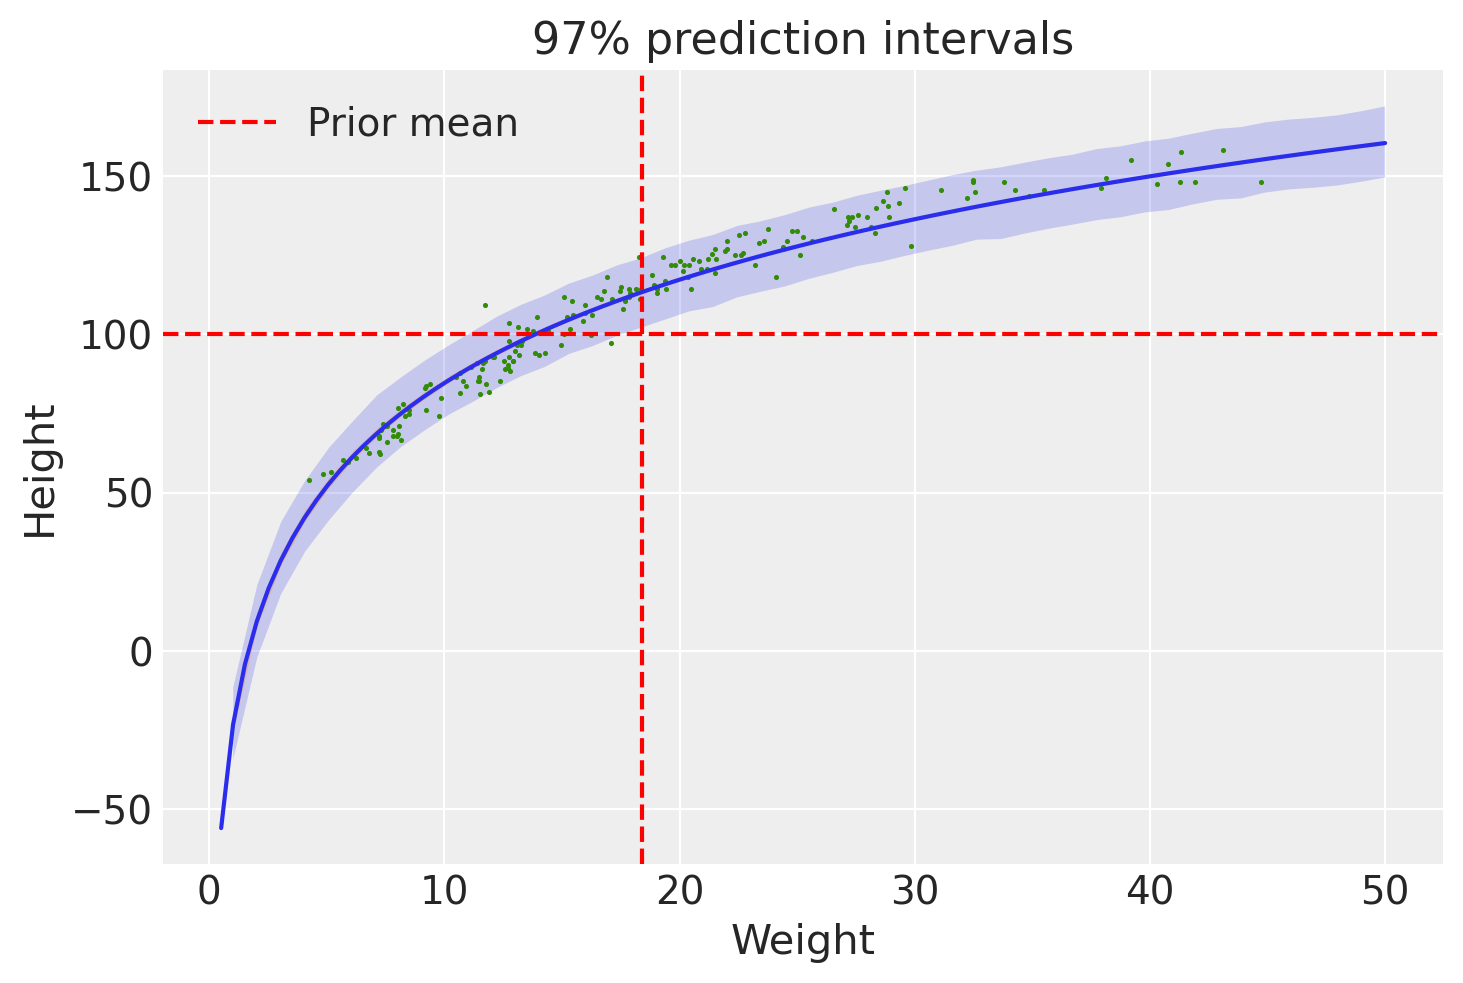

In [39]:
# compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"] * (
    np.log(np.linspace(0, 50, 100)) - np.mean(howell1.log_weight)
)
pred_intervals = np.array(
    [
        az.hdi(
            np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2]),
            hdi_prob=0.97,
        )
        for x in np.log(np.linspace(0, 50))
    ]
)
plt.fill_between(np.linspace(0, 50), pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2)
plt.fill_between(np.linspace(0, 50), cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.3)
plt.plot(np.linspace(0, 50, 100), mu)
plt.scatter(y_data.weight, y_data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("97% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--", c="r")
plt.axhline(100, ls="--", c="r", label="Prior mean")
plt.legend();

Using a log transform of the data appears to give sensible results for our observations. Obviously, extrapolating this fit too far will give terrible conclusions.

### 4H4.
Plot the prior predictive distribution for the parabolic polynomial regression model in the
chapter. You can modify the code that plots the linear regression prior predictive distribution. Can
you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to
keep the curves consistent with what you know about height and weight, before seeing these exact
data.

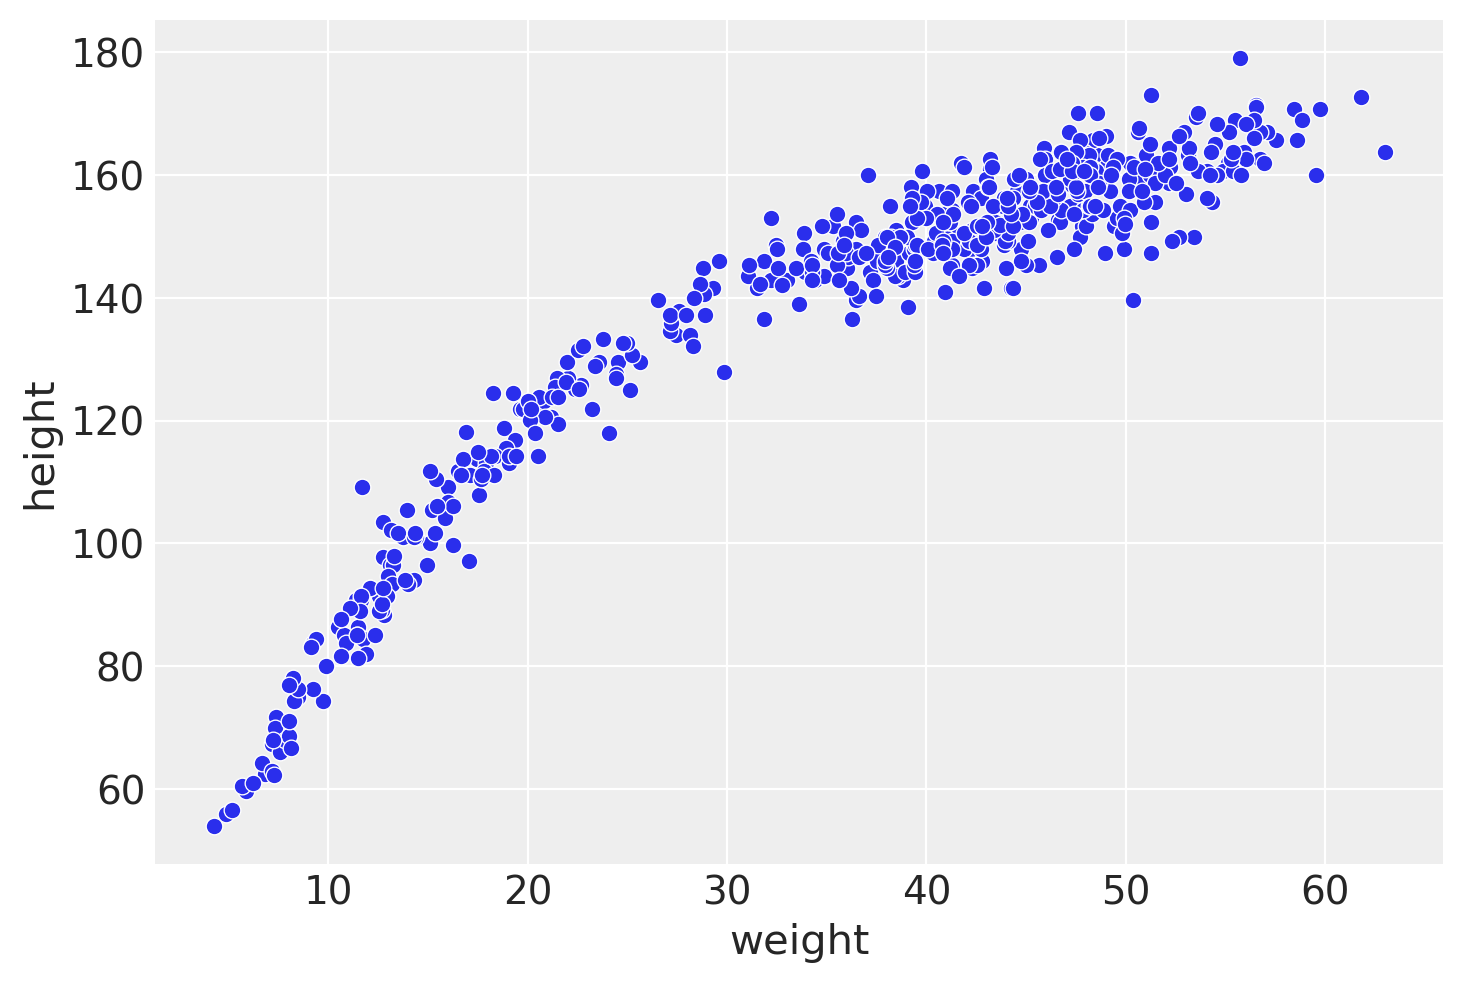

In [40]:
sns.scatterplot(x="weight", y="height", data=howell1);

#### Answer

The justifications for the priors are written along side:

$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_1 (x_i - \overline{x}) - \beta_2(x_i - \overline{x})^2 $ #Note that it's -$\beta_2$. Positive prior on $\beta$ ensures the paraboloid curves in the correct direction.

$\alpha$ ~ $N(150,30^2)$ # Reduced mean height at mean weight, as we are looking at a much larger age range now, so we expect younger people to drag the mean height down at any given weight relative to the adult only data set

$\beta_1$ ~ $Lognormal(0,1)$ # Need a linear base line to perturb with a quadratic term


The seconds term puts a small deviation from linearity

$\beta_2$ ~ $exp(0.05)$ #This should be positive to ensure concavity, and small to ensure small only small perturbation from linearity in weights

$\sigma$ ~ $Unif(0,50)$

In [41]:
# Generate prior predictive checks
with pm.Model() as model:
    alpha = pm.Normal("alpha", 150, 30)
    b1 = pm.Lognormal("b1", 0, 1)
    b2 = pm.Exponential("b2", 1 / 0.05)
    sigma = pm.Uniform("sigma", 0, 1)
    mu = (
        alpha
        + b1 * (howell1.weight - np.mean(howell1.weight))
        - b2 * (howell1.weight - np.mean(howell1.weight)) ** 2
    )
    H = pm.Normal("H", mu=mu, sigma=sigma, observed=howell1.height)
    pp = pm.sample_prior_predictive(samples=1000)  # compute prior predictions

In [42]:
x = np.linspace(0, 70)
mh = np.mean(howell1.weight)
means = pp["alpha"] + np.outer(x - mh, pp["b1"]) - np.outer((x - mh) ** 2, pp["b2"])

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


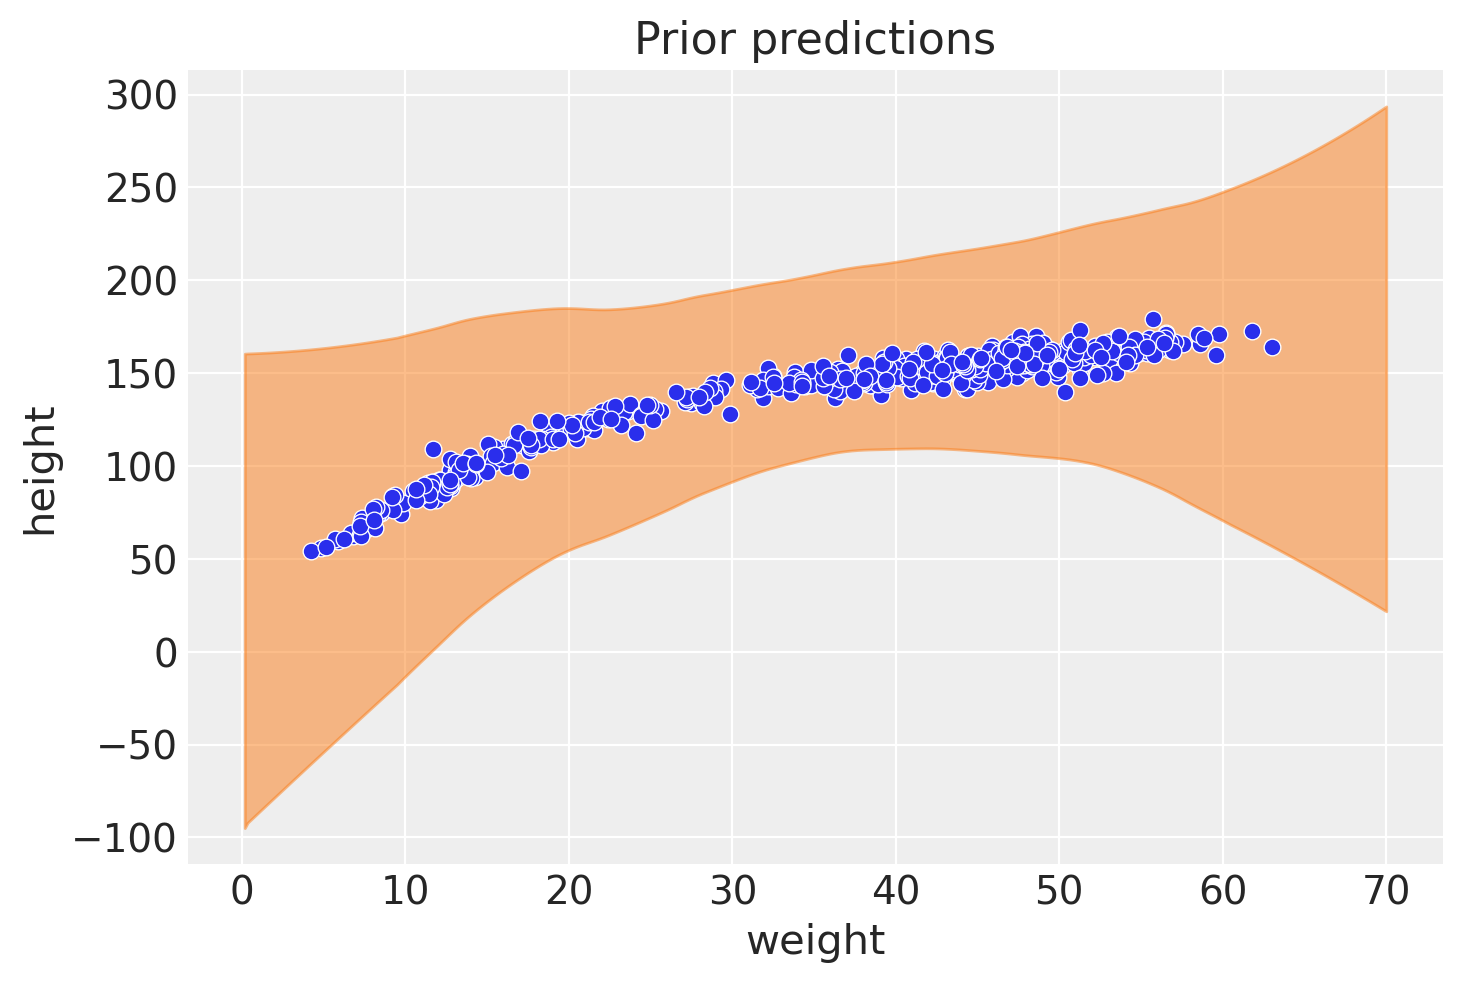

In [43]:
az.plot_hdi(x, means.T, hdi_prob=0.89)
sns.scatterplot(x="weight", y="height", data=howell1)
plt.title("Prior predictions");

By using an exponential prior on $\beta_2$ this ensures the parabolic curve must be concave, thus no increasing growth in height with weight is possible and makes perfect sense on physical grounds. However, extreme and absurd values are still found near the extremes of the data. One could tighten the parameters to ensure this didn't happen, but as a first approximation this isn't too bad.

In [44]:
%watermark -n -u -v -iv -w

Last updated: Tue Dec 22 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

arviz     : 0.9.0
pymc3     : 3.9.3
scipy     : 1.5.2
seaborn   : 0.11.0
numpy     : 1.19.1
matplotlib: 3.3.2
pandas    : 1.1.3

Watermark: 2.1.0

